###  MicroGrad demo

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
np.random.seed(1337)
random.seed(1337)

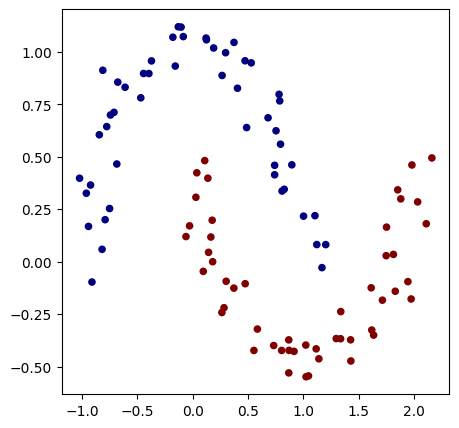

In [12]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [13]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(2, [16, 16, 1], act='relu') # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2), relu-Neuron(2)], Layer of [relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16), relu-Neuron(16)], Layer of [linear-Neuron(16)]]
number of parameters 337


In [14]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0.0, lr=1.0) 0.5


In [15]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.learn(0.5, 1.1)

total_loss, acc = loss()
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.9088347045524516, accuracy 80.0%
step 2 loss 0.5741145909807759, accuracy 86.0%
step 3 loss 0.46100488827233865, accuracy 85.0%
step 4 loss 0.3969958296978047, accuracy 86.0%
step 5 loss 0.35000456794717216, accuracy 86.0%
step 6 loss 0.3292398820678249, accuracy 87.0%
step 7 loss 0.299714033129511, accuracy 87.0%
step 8 loss 0.28577012808733826, accuracy 87.0%
step 9 loss 0.27051906189674135, accuracy 89.0%
step 10 loss 0.256428353348976, accuracy 90.0%
step 11 loss 0.24402267061108593, accuracy 92.0%
step 12 loss 0.23452759965946623, accuracy 92.0%
step 13 loss 0.2279677239066439, accuracy 92.0%
step 14 loss 0.21807187773587403, accuracy 94.0%
step 15 loss 0.21119963901495822, accuracy 94.0%
step 16 loss 0.20465387467159127, accuracy 95.0%
step 17 loss 0.19466159249529255, accuracy 95.0%
step 18 loss 0.18513056254153293, accuracy 95.0%
step 19 loss 0.17505181857384847, accuracy 95.0%
step 20 loss 0.16530305459385325, accura

In [19]:
lrs = [p for p in model.parameters()]
lrs.sort(key = lambda p: p.learning_rate)
lrs[200:]

[Value(data=0.6837525451520841, grad=0.00013689256240531004, lr=5.188498644383117),
 Value(data=0.8341790843072866, grad=0.0001670091221822658, lr=5.188498644383117),
 Value(data=0.9210413315680648, grad=0.00018439961774695393, lr=5.188498644383117),
 Value(data=0.5758187679091107, grad=0.00011528338311722687, lr=5.188498644383117),
 Value(data=-0.006901279012527611, grad=-1.3816895814095424e-06, lr=5.188498644383117),
 Value(data=-0.3164463830086644, grad=-6.343409279169413e-05, lr=11.414697017642858),
 Value(data=-0.14245788776430557, grad=-2.855677093045579e-05, lr=11.414697017642858),
 Value(data=-0.5520069064939888, grad=-0.0001106539976702371, lr=11.414697017642858),
 Value(data=-1.0181143788944371, grad=-0.00020408879813797542, lr=11.414697017642858),
 Value(data=-0.4283880796529778, grad=-8.587366029340461e-05, lr=11.414697017642858),
 Value(data=-0.034350868624713746, grad=-6.885893803234666e-06, lr=11.414697017642858),
 Value(data=-0.1433974038472569, grad=-2.87451041002604e-

In [20]:
# visualize decision boundary
def visual():
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# tanh

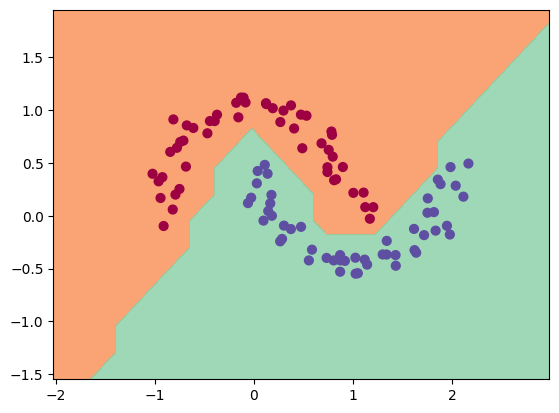

In [8]:
visual()

# relu

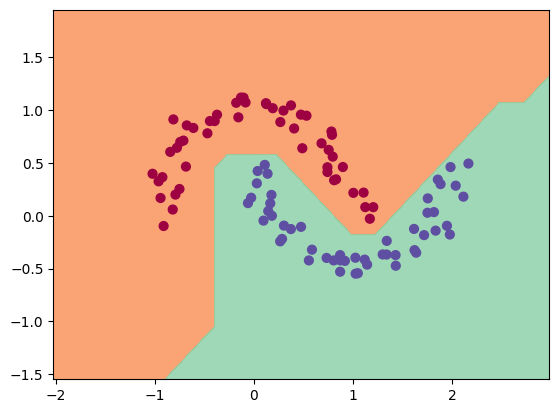

In [12]:
visual()

# tanh with dynamic learning rate <0.5, 1.1>

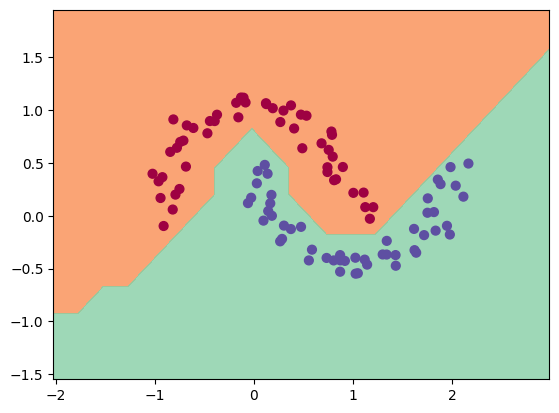

In [8]:
visual()

# relu with dynamic learning rate <0.5, 1.1>

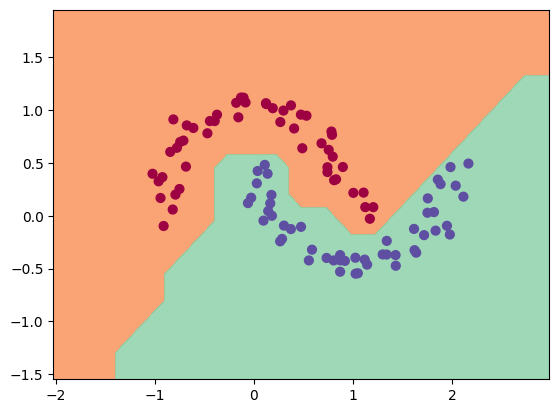

In [22]:
visual()